In [1]:
import configparser
config = configparser.ConfigParser()
config.read("config_v1.txt")
account_id = config['oanda']['account_id']
api_key = config['oanda']['api_key']

In [8]:
import datetime
import pandas
from oandapyV20 import API
import oandapyV20.endpoints.instruments as oandapy

start        = datetime.datetime(year=2018,month=12,day=28)
minutes      = 150 # 150分取得
start        = start.strftime("%Y-%m-%dT%H:%M:00.000000Z")
access_token = api_key
api          = API(access_token = access_token, environment="practice")
request      = oandapy.InstrumentsCandles(instrument = "USD_JPY",
               params = { "alignmentTimezone": "Japan", "from": start, "count": minutes, "granularity": "M1" })
api.request(request)

filename = "candle.csv"
candle = pandas.DataFrame.from_dict([ row['mid'] for row in request.response['candles'] ])
candle['time'] = [ row['time'] for row in request.response['candles'] ]
candle.to_csv(filename)

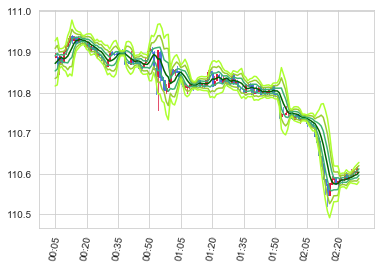

In [9]:
import pandas
import seaborn
import matplotlib
import matplotlib.pyplot as plt
from mpl_finance import candlestick2_ohlc as plt_candle
seaborn.set_style("whitegrid")

# csvを読み込む
candle = pandas.read_csv('candle.csv')

# 移動平均とボラティリティを求める
window_size  = 5 #5分移動平均を求める
avg_move     = pandas.Series.rolling(candle.c, window = window_size).mean().dropna().reset_index(drop = True)
sigma        = pandas.Series.rolling(candle.c, window = window_size).std(ddof = 0).dropna().reset_index(drop = True)
sigma_plus1  = avg_move + sigma
sigma_plus2  = avg_move + sigma * 2
sigma_plus3  = avg_move + sigma * 3
sigma_minus1 = avg_move - sigma
sigma_minus2 = avg_move - sigma * 2
sigma_minus3 = avg_move - sigma * 3

candle = candle[window_size:].reset_index(drop = True)

# X軸の見た目を整える
# 時間だけを切り出すために先頭からの12文字目から取るようにしている
xticks_number = 15 #15分刻みに目盛りを書く
xticks_index = range(0,len(candle), xticks_number)
xticks_date = [candle.time.values[i][11:16] for i in xticks_index]

figure, ax = plt.subplots()
plt_candle( ax,
            opens = candle.o.values,
            highs = candle.h.values,
            lows = candle.l.values,
            closes = candle.c.values,
            width=0.6,
            colorup='#DC143C',
            colordown='#4169E1')
plt.plot(avg_move, color='#006400')
plt.plot(sigma_plus1, color='#3CB371')
plt.plot(sigma_plus2, color='#9ACD32')
plt.plot(sigma_plus3, color='#ADFF2F')
plt.plot(sigma_minus1, color='#3CB371')
plt.plot(sigma_minus2, color='#9ACD32')
plt.plot(sigma_minus3, color='#ADFF2F')
plt.xticks(xticks_index, xticks_date, rotation=80)
plt.show()


In [10]:
%ls

USD_JPY_Week2.csv*  candle.csv          oanda.py
Untitled.ipynb      config_v1.txt       基本操作.ipynb


/Users/onishiryoya/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


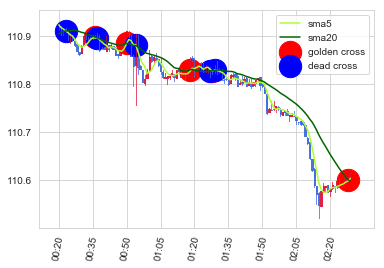

In [11]:
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
from mpl_finance import candlestick2_ohlc as plt_candle
seaborn.set_style("whitegrid")

# csvを読み込む
candle = pd.read_csv('candle.csv')

#移動平均を求める
small_window = 5 # 5分平均線を求める
big_window   = 20 #　20分平均線求める
sma5         = pd.Series.rolling(candle.c, window = small_window).mean()
sma20        = pd.Series.rolling(candle.c, window = big_window).mean()

candle = candle[ big_window: ].reset_index(drop=True)
sma5 = sma5[ big_window: ].reset_index(drop=True)
sma20 = sma20[ big_window: ].reset_index(drop=True)

#ゴールデンクロス、デッドクロスを見つける
cross  = sma5 > sma20
golden = (cross != cross.shift(1)) & (cross == True)
dead   = (cross != cross.shift(1)) & (cross == False)

#ゴールデンクロス、デッドクロスの位置をリスト化する
index_g = [i-1 for i, x in enumerate(golden) if x == True]
index_d = [i-1 for i, x in enumerate(dead) if x == True]

# X軸の見た目を整える
# 時間だけを切り出すために先頭からの12文字目から取るようにしている
xticks_number = 15 #15分刻みに目盛りを書く
xticks_index = range(0,len(candle), xticks_number)
xticks_date = [candle.time.values[i][11:16] for i in xticks_index]

figure, ax = plt.subplots()
plt_candle( ax,
            opens = candle.o.values,
            highs = candle.h.values,
            lows = candle.l.values,
            closes = candle.c.values,
            width=0.6,
            colorup='#DC143C',
            colordown='#4169E1')
plt.plot(sma5, color='greenyellow', label='sma5')
plt.plot(sma20, color='darkgreen', label='sma20')
plt.scatter(index_g, sma20[index_g], color='red', s=500, label="golden cross")
plt.scatter(index_d, sma20[index_d], color='blue', s=500, label="dead cross")
plt.xticks(xticks_index, xticks_date, rotation=80)
plt.legend()
plt.show()